In [18]:
# Doing this patches in a bunch of methods that are required for the training example below.
from fastai.vision.all import *

In [19]:
# These imports are redundant, but I'm using it to refresh my memory on the API.

from fastai.vision.data import ImageDataLoaders, get_image_files
from fastai.data.external import URLs, untar_data

`untar_data` takes in a URL to a gzipped tarfile, unzips it then returns the path (as a `pathlib.Path` object).

In [20]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz'

In [21]:
path = untar_data(URLs.PETS)/'images'

In the Oxford Pets dataset (or at least the one hosted by fastai), the files are named so that if it starts with a capital letter it's a cat. Here's a few examples:

In [22]:
get_image_files(path)

(#7390) [Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_115.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_18.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_157.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_28.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_6.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_79.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_128.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Persian_265.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_182.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/keeshond_89.jpg')...]

So we can write a function that returns True if is starts with an uppercase char.

In [23]:
def is_cat(x):
    return x[0].isupper()

In [24]:
assert is_cat('Persian_265.jpg')
assert is_cat('beagle_115.jpg') is False

We can use `ImageDataLoaders` to load each image and extract the labels. First argument is a path and second is the list of files to load.

It takes a number of additional arguments for preparing validation sets and passing item transforms.

In [25]:
from fastai.vision.augment import Resize

In [26]:
dataloaders = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=420,
    label_func=is_cat, item_tfms=Resize(224))

In [27]:
dataloaders

We can then get a "learner" instance by passing the dataloaders and architecture function.

In [28]:
from torchvision.models.resnet import resnet34
from fastai.vision.learner import cnn_learner
from fastai.metrics import error_rate

In [29]:
learn = cnn_learner(dataloaders, resnet34, metrics=error_rate)

And fine-tune the top layers:

In [30]:
learn

In [31]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.139675,0.018890,0.005413,00:42


epoch,train_loss,valid_loss,error_rate,time
0,0.063200,0.014935,0.006089,00:44


Now to test the model.

In [32]:
from fastai.vision import widgets
from fastai.vision.core import PILImage

In [33]:
uploader = widgets.FileUpload()

In [34]:
uploader

FileUpload(value={}, description='Upload')

In [35]:
img = PILImage.create(uploader.data[0])

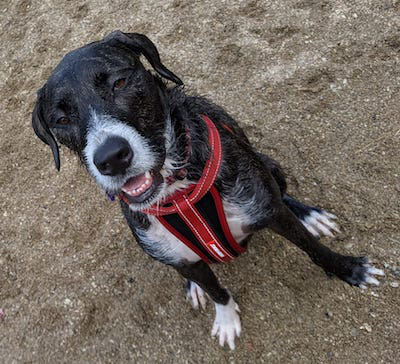

In [36]:
img

In [37]:
is_cat, _, probs = learn.predict(img)

In [38]:
print(f"Is this a cat?: {is_cat}.")

Is this a cat?: False.


In [39]:
print(f"Dog probability: {1-probs[1].item():.6f}")

Dog probability: 1.000000


We know the model has only been trained on cat / dog photos. What happens if we try anime cats?

In [40]:
uploader

FileUpload(value={'doggo.jpg': {'metadata': {'name': 'doggo.jpg', 'type': 'image/jpeg', 'size': 42952, 'lastMo…

In [41]:
img = PILImage.create(uploader.data[0])

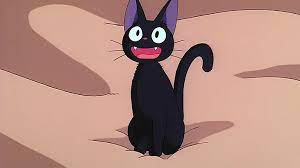

In [42]:
img

In [43]:
is_cat, _, probs = learn.predict(img)

In [44]:
print(f"Is this a cat?: {is_cat}.")
print(f"Cat probability: {probs[1].item():.6f}")

Is this a cat?: True.
Cat probability: 0.995966


Still works, but it's not very confident.